# Mixtures of Gaussians



A Gaussian mixture distribution can be written as a linear superposition of K Gaussians:

\begin{equation}
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)
\end{equation}

where $\pi_k$ are the mixing coefficients, $\mu_k$ are the means, and $\Sigma_k$ are the covariances.

Let $z$ be a $K-dimensional$ binary random variable having a 1-of-K representation (i.e. one element is equal to 1 and the rest are 0). This is a latent variable that represents the identity of the component Gaussian that generated the data point $x$. The values of $z_k$ must satisfy $z_k \in \{0, 1\}$ and $\sum_{k=1}^K z_k = 1$.

The joint distribution of $x$ and $z$, $p(x, z)$ can be written in terms of the marginal distribution $p(z)$ and the conditional distribution $p(x|z)$:

\begin{equation}
p(x, z) = p(z) \ p(x|z)
\end{equation}

The marginal distribution over $z$ is specified by the mixing coefficients:

\begin{equation}
p(z_k = 1) = \pi_k
\end{equation}

where the parameters $\pi_k$ are constrained such that $0 \leq \pi_k \leq 1$ along with 

\begin{equation}
\sum_{k=1}^K \pi_k = 1
\end{equation}

to ensure the mixing coefficients are valid probabilities. As $z$ uses a 1-of-K representation, the marginal distribution over $z$ can be written as:

\begin{equation}
p(z) = \prod_{k=1}^K \pi_k^{z_k}
\end{equation}

The conditional distribution over $x$ given a particular value of $z$ is specified by a Gaussian distribution:

\begin{equation}
p(x|z_k=1) = \mathcal{N}(x|\mu_k, \Sigma_k)
\end{equation}

which can be written in the form:

\begin{equation}
p(x|z) = \prod_{k=1}^K \mathcal{N}(x|\mu_k, \Sigma_k)^{z_k}
\end{equation}

The marginal distribution of $x$ is then the sum of the marginal distribution $x$ and $z$ over all possible values of $z$:

\begin{equation}
p(x) = \sum_{z} p(x, z) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)
\end{equation}

which is a Gaussian mixture distribution. As a result, each data point $x_n$ has a latent variable $z_n$ that represents the identity of the component Gaussian that generated the data point $x_n$. The use of the joint distribution, instead of the marginal distribution of $x$, allows significany simplifications to be made most notably through the introduction of the EM algorithm. 

One other important quantity that will play an important role is the conditional probability of $z$ given $x$. This can be denoted as $\gamma \ (z_k)$ to deonte $p(z_k = 1 | x)$ which can be found using Bayes' theorem:

\begin{equation}
\gamma (z_k) \equiv p(z_k = 1 | x) = \frac{p(z_k = 1) \ p(x|z_k=1)}{\sum_{j=1}^{K} p(z_j = 1) \ p(x|z_j = 1)}
\end{equation}

\begin{equation}
= \frac{\pi_k \mathcal{N}(x|\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x|\mu_j, \Sigma_j)}
\end{equation}

$\pi_k$ can be viewed as the prior probability that $z_k = 1$, and $\gamma (z_k)$ can be viewed as the corresponding posterior probability that $z_k = 1$ after having observed $x$. Alternatively, $\gamma (z_k)$ can be viewed as the *responsibility* that component $k$ takes for explaining the data point $x$. 



Iteration 1
--------


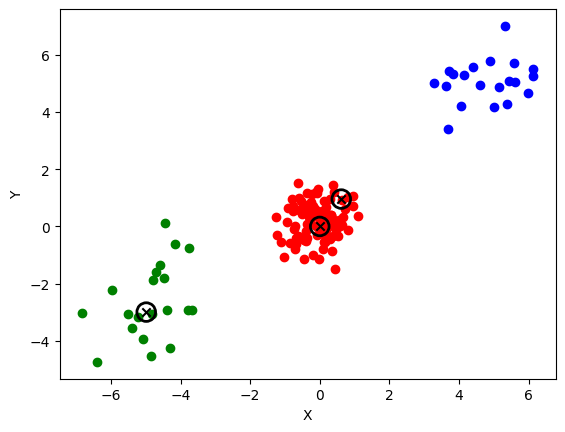

Iteration 2
--------


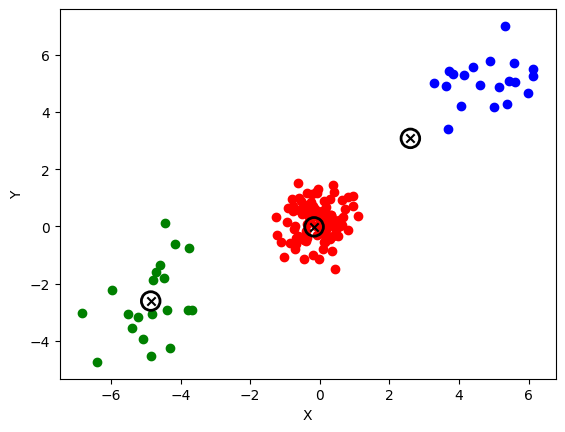

Iteration 3
--------


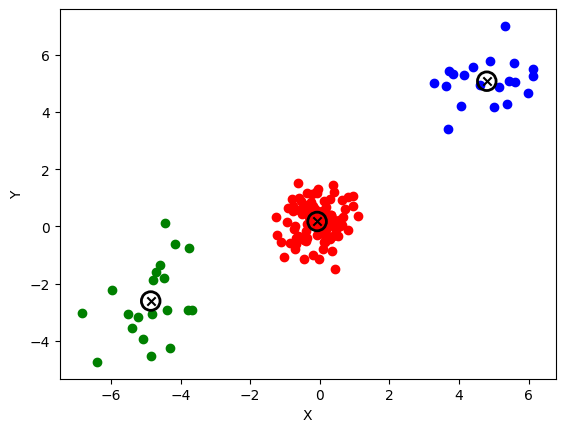

Iteration 4
--------


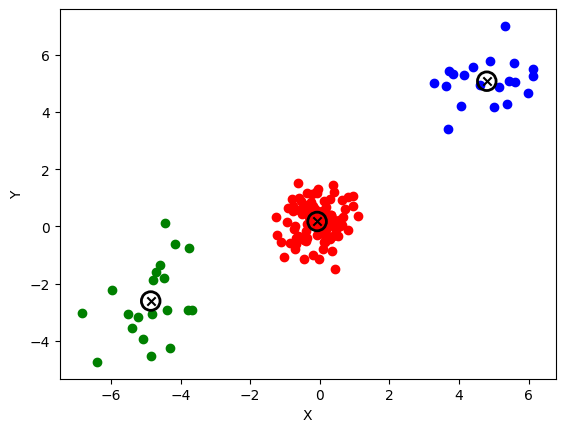

Iteration 5
--------


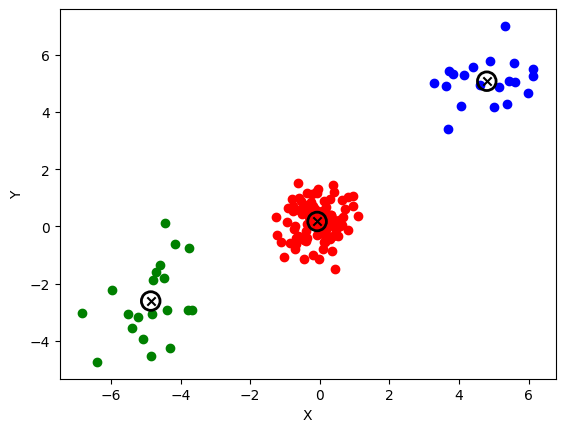

In [324]:
# Lets run K-means for initialisation for the GMM 


import torch 
from torch.distributions import MultivariateNormal
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Generate some data
torch.manual_seed(42)

cluster_1 = MultivariateNormal(torch.tensor([[0., 0.]]), torch.tensor([[.25, 0.], [0., .5]])).sample((100,)).squeeze(1)
cluster_2 = MultivariateNormal(torch.tensor([[5., 5.]]), torch.tensor([[.75, 0.], [0., 1.]])).sample((20,)).squeeze(1)
cluster_3 = MultivariateNormal(torch.tensor([[-5., -3.]]), torch.tensor([[.5, 0.], [0., 1.5]])).sample((20,)).squeeze(1)
data = torch.cat([cluster_1, cluster_2, cluster_3], dim=0)

K = 3 # Number of clusters

# choose random centroids 
mu_k = torch.randint(low=-10, high=10, size=(K, 2)) # Initialise cluster selection

for i in range(5):
    # E-step 
    distances = (data.unsqueeze(1) - mu_k.unsqueeze(0).repeat(data.shape[0], 1, 1)).pow(2).sum(dim=-1) # distances to clusters
    r_k = torch.argmin(distances, dim=-1) # assign data points to clusters
    r_k = F.one_hot(r_k, num_classes=K).float()

    # M-step 
    mu_k = torch.sum(r_k.unsqueeze(-1).repeat(1, 1, 2) * data.unsqueeze(1).repeat(1, 3, 1), axis=0) / (r_k.sum(dim=0).unsqueeze(1).repeat(1, 2) + 1e-6)


    # Plot the results 
    print(f"Iteration {i + 1}")
    plt.figure()
    plt.scatter(cluster_1[:, 0], cluster_1[:, 1], c="r")
    plt.scatter(cluster_2[:, 0], cluster_2[:, 1], c="b")
    plt.scatter(cluster_3[:, 0], cluster_3[:, 1], c="g")

    plt.scatter(mu_k[:, 0], mu_k[:, 1], c="k", marker="x")
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c="none", edgecolors="k", s=180, linewidths=2)
    plt.xlabel("X")
    plt.ylabel("Y")
    print("--------")
    plt.show()

In [349]:
# Initialisation of the GMM inputs 

# mu_k determined from K-means 
print(mu_k.shape)
Sigma_k = torch.eye(2,2).unsqueeze(0).repeat(K,1,1)
pi_k = torch.ones((K)) / K

torch.Size([3, 2])


In [356]:
# Expectation
gamma_z = torch.cat([torch.exp(MultivariateNormal(mu_k, Sigma_k).log_prob(data[i, :])) for i in range(data.shape[0])]).reshape(data.shape[0], 3)
print(gamma_z.sum())
gamma_z /= torch.sum(gamma_z, axis=1).unsqueeze(-1) # Normalise the gamma_z

tensor(27.8851)


In [357]:
# Maximization 
N_k = torch.sum(gamma_z, axis=0)
mu_k = (1/N_k).repeat(2, 1).T * torch.sum(gamma_z.unsqueeze(-1) * data.unsqueeze(1).repeat(1, 3, 1), axis=0) 

delta = data.unsqueeze(1).repeat(1, 3, 1) - mu_k.unsqueeze(0).repeat(data.shape[0], 1, 1)
Sigma_k = (1/N_k).T.unsqueeze(-1).unsqueeze(-1) * torch.sum((torch.matmul(delta.unsqueeze(-1), delta.unsqueeze(-2)) * gamma_z.unsqueeze(-1).unsqueeze(-1)), axis=0)
pi_k = N_k / data.shape[0]

In [364]:
# This should be repeeated until the log likelihood (gamma_z) converges

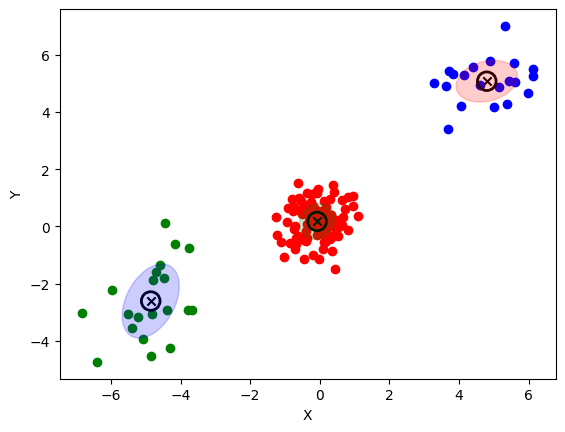

In [363]:
plt.figure()
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], c="r")
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], c="b")
plt.scatter(cluster_3[:, 0], cluster_3[:, 1], c="g")

plt.scatter(mu_k[:, 0], mu_k[:, 1], c="k", marker="x")
plt.scatter(mu_k[:, 0], mu_k[:, 1], c="none", edgecolors="k", s=180, linewidths=2)
plt.xlabel("X")
plt.ylabel("Y")


# Plot ellipsoids corresponding to the mean and covariances of each Gaussian
from matplotlib.patches import Ellipse
import numpy as np

def plot_ellipse(pos, cov, ax=None, **kwargs):
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    ax.add_artist(ellipse)

for k in range(K):
    plot_ellipse(mu_k[k], Sigma_k[k].detach().numpy(), alpha=0.2, color=['r', 'b', 'g'][k])

plt.show()
